In [2]:
current_path = '/content/drive/My Drive/Colab Notebooks/Project_GANder/gankook_cuda/semantic-segmentation-pytorch/pytorch.room.layout/'

import os
os.chdir(current_path)
!ls

build		      drn.py		     requirements.txt
cv2_requirements.txt  features		     segment_rl.py
datasets	      lsun.pth.tar	     segment_st.py
data_transforms.py    lu_vp_detect.egg-info  sunrgbd.pth.tar
dist		      pics		     test_result
drn_d_105_024_val     __pycache__	     visualize.m
drn_d_105_024_val_ms  README.md		     XiaohuLuVPDetection


### Get Vanishing point, inliers

In [3]:
# !python XiaohuLuVPDetection/setup.py build
# !python XiaohuLuVPDetection/setup.py install
!pip install -r cv2_requirements.txt

     |████████████████████████████████| 25.4MB 119kB/s 
     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
import cv2
cv2.__version__

'4.0.0'

### pytorch.room.layout

In [ ]:
# !pip install -r requirements.txt
# !apt install octave

In [ ]:
import torch
torch.__version__

In [ ]:
!python segment_rl.py train -d datasets/lsun/ -c 4 -s 480 --arch drn_d_105 --batch-size 32 --random-scale 1.75 --random-rotate 15 --epochs 100 --lr 0.01 --momentum 0.9 --lr-mode poly --pretrained sunrgbd.pth.tar

In [ ]:
!python segment_st.py test -d datasets/sunrgbd/ -c 37 --arch drn_d_105 -s 480 --resume sunrgbd.pth.tar --phase val --batch-size 1 --ms

In [ ]:
!python segment_rl.py test -d datasets/lsun/ -c 4 --arch drn_d_105 -s 320 --resume lsun.pth.tar --phase val --batch-size 1 --ms

### Functions

In [5]:
#             Detect Intersection             #
from collections import defaultdict
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sympy import Line


def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection2(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


def regression(img, x, y, color=(255, 0, 0)):

  y_at_border = np.array([0, img.shape[0]])
  p = np.polyfit(y, x, deg=1)
  x_at_border = np.poly1d(p)(y_at_border)

  cv2.line(img, (int(x_at_border[0]), int(y_at_border[0])), (int(x_at_border[1]), int(y_at_border[1])), color, 2)

  return x_at_border, y_at_border


def drawLines(img, lines, color=(255,0,0)):
  """
  Draw lines on an image
  """

  centroids = list()
  r_xs = list()
  r_ys = list()
  for line_ in lines:
      for rho,theta in line_:
          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a*rho
          y0 = b*rho
          x1 = int(x0 + 1000*(-b))
          y1 = int(y0 + 1000*(a))
          x2 = int(x0 - 1000*(-b))
          y2 = int(y0 - 1000*(a))

          slope = (y1 - y0) / float(x1 - x0)
          angle = math.degrees(math.atan(slope))
          if abs(angle) > 80:
            # print(img.shape[1])
            h_layout = line((0, 0), (img.shape[1], 0))
            h_layout_lower = line((0, img.shape[0]), (img.shape[1], img.shape[0]))
            r = intersection2(h_layout, line((x1, y1), (x2, y2)))
            r_lower = intersection2(h_layout_lower, line((x1, y1), (x2, y2)))
            # cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.line(img, (int(r[0]), int(r[1])), (int(r_lower[0]), int(r_lower[1])), color, 2)
            center_p = (int((r[0] + r_lower[0]) / 2), int((r[1] + r_lower[1])/ 2))
            centroids.append(center_p)

            r_xs.append((r[0], r_lower[0]))
            r_ys.append((r[1], r_lower[1]))
            cv2.circle(img, center_p, 10, (255, 0, 255), -1)

  cv2.line(img, (int(0), int(0)), (int(0), int(img.shape[0])), color, 2)
  cv2.line(img, (int(img.shape[1]), int(0)), (int(img.shape[1]), int(img.shape[0])), color, 2)
  cv2.circle(img, (0, int(img.shape[0] / 2)), 10, (255, 0, 255), -1)
  cv2.circle(img, (img.shape[1], int(img.shape[0] / 2)), 10, (255, 0, 255), -1)
  centroids.append((0, int(img.shape[0] / 2)))
  centroids.append((img.shape[1], int(img.shape[0] / 2)))

  return r_xs, r_ys, centroids   

from scipy.spatial import distance as sci_dist

def order_points(pts):

  xSorted = pts[np.argsort(pts[:, 0]), :]
  leftMost = xSorted[:2, :]
  rightMost = xSorted[2:, :]
  leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
  (tl, bl) = leftMost
  D = sci_dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
  (br, tr) = rightMost[np.argsort(D)[::-1], :]

  return np.array([tl, tr, br, bl], dtype="float32")



image_index : 10
b11f628608c14cb70d252aec023220c0a11312e7.png
scale_factor : 6
len(r_x_list), len(r_y_list) : 1 1
centroids_data.shape : (3, 1)
k is 3
[1 2 0]
keys : [1]
[171.69883189  87.10766887] [  0 480]
len(left_vh_intersections) : 4
len(right_vh_intersections) : 10
[0.36611084861489623, 0.06992928664617964, 0.0054309121741579446]
k is  4
[0 0 0 0 1 1 1 1 0 0 3 2]
keys : [0, 1]
len(temp_inter_left) : 6
len(temp_inter_right) : 6
len(temp_inter_left) : 4
len(temp_inter_right) : 4
np.array(all_closest_inters).shape : (1, 2, 4)
len(all_closest_inters) : 1
inters_i == len(all_closest_inters) - 1
four_inters : [(121.32341311919153, 285.84783737265633), (154.7671658774221, 96.0762259001607)]
h_intersections : [(121.41467498219254, 285.3299854756851, 480.0, 333.3937487275096), (-0.0, 50.170146475780015, 156.41494205136507, 86.72616455579839), (-0.0, 305.0952764060715, 121.23215125619052, 286.3656892696276), (153.11938970347913, 105.426287244523, 480.0, 106.12941355513675)]
four_inters : [

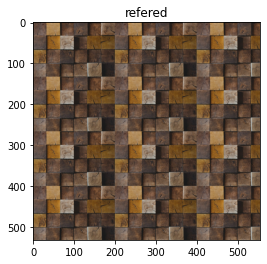

src : [[  0.        0.     ]
 [555.63367   0.     ]
 [555.63367 532.08154]
 [  0.      532.08154]]
dst : [[ 84.59117   0.     ]
 [392.89233   9.52944]
 [392.89233 532.08154]
 [  0.      480.     ]]


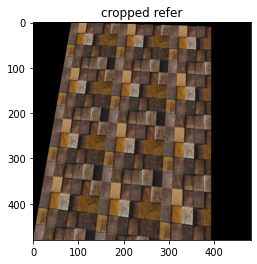

int(min_x) : 87
int(min_y) : 0
iter : True
four_inters : [(121.32341311919153, 285.84783737265633), (154.7671658774221, 96.0762259001607)]
h_intersections : [(121.41467498219254, 285.3299854756851, 480.0, 333.3937487275096), (-0.0, 50.170146475780015, 156.41494205136507, 86.72616455579839), (-0.0, 305.0952764060715, 121.23215125619052, 286.3656892696276), (153.11938970347913, 105.426287244523, 480.0, 106.12941355513675)]
intersection2(v_border, hline) : (-0.0, 50.170146475780015)
intersection2(v_border, hline) : (-0.0, 305.0952764060715)
four_inters : [(121.32341311919153, 285.84783737265633), (154.7671658774221, 96.0762259001607), [-0.0, 50.170146475780015], [-0.0, 305.0952764060715]]
shorter_points : [array([121.32341, 285.84784], dtype=float32), array([154.76717 ,  96.076225], dtype=float32)]
shorter x, y : (121.32341, 154.76717) (285.84784, 96.076225)
[  0.    493.819]
[ 87.107666 480.      ]
[  0.      -50.92826]
[171.69884   0.     ]
src_x : 242.8188243254539


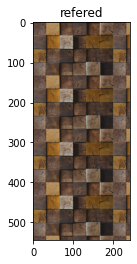

src : [[  0.        0.     ]
 [242.81882   0.     ]
 [242.81882 544.74725]
 [  0.      544.74725]]
dst : [[  0.         0.      ]
 [171.69884   50.92826 ]
 [ 87.107666 530.9283  ]
 [  0.       544.74725 ]]


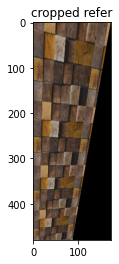

int(min_x) : 0
int(min_y) : -50
elapsed time : 3.52480149269104
[121.32341312 285.84783737]
[154.76716588  96.0762259 ]
[-0.         50.17014648]
[ -0.         305.09527641]


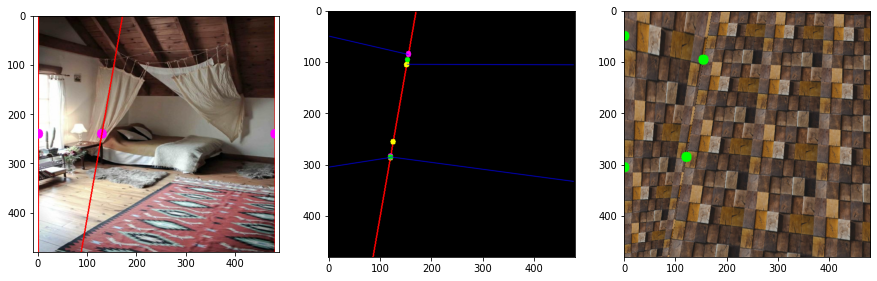

In [16]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from XiaohuLuVPDetection.lu_vp_detect.vp_detection import VPDetection
import time


length_thresh = 50
principal_point = None
focal_length = 1300 # 1102.79
seed = 1300
vpd = VPDetection(length_thresh, principal_point, focal_length, seed)

# import os
import cv2
import pylab as pl
from skimage import morphology as mp
import sys


org_path = 'datasets/lsun/images/'
image_path = 'drn_d_105_024_val_ms/images/'
refer_path = '../refer_data/wall/myxkehu1kfzggursepnk0tfiyps8zbs5umvzv8d92r6hhxejgawebwsufssgov5q-.jpg'
val_image_list = os.listdir(image_path)

one_iter = False
start_index = 0
for image_index, image in enumerate(val_image_list):

  if image_index < start_index:
    continue
  image = 'b11f628608c14cb70d252aec023220c0a11312e7.png'
  print('image_index :', val_image_list.index(image))
  one_iter = True

  # print(image)
  img = Image.open(image_path + image)
  # print(type(img))
  img_np = np.invert(np.asarray(img))
  # print(img_np.max(), img_np.min())
  ret, thr = cv2.threshold(img_np, 254, 255, cv2.THRESH_BINARY_INV)
  # img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
  # img_bgr_np = np.asarray(img_rgb)

  org = Image.open(org_path + image)
  org_np = np.asarray(org)

  # vps = vpd.find_vps(org_np)
  vps = vpd.find_vps(org_path + image)
  vl_img = vpd.create_debug_VP_image()
  # print(img_np.shape, org_np.shape, (img_np.dtype), (org_np.dtype))


  # print(img_np.shape, org_np.shape)

  # concat = np.hstack((org_np, img_np))
  print(image)
  # plt.subplot(131)
  # plt.imshow(org)
  # plt.show()
  img_size = (org_np.shape[1], org_np.shape[0])
  
  scale_factor = 6
  print('scale_factor :', scale_factor)

  refer = Image.open(refer_path)
  refer = np.asarray(refer)
  # if scale_factor >= 1:

  #     refer_size와 img_size가 동일하거나 refer_size가 작은 경우를 고려해야한다.     #
  refer = np.tile(refer, (scale_factor, scale_factor, 1))
  size_ratio = math.floor(min((refer.shape[0] / (org_np.shape[0] * 1.5)), (refer.shape[1] / (org_np.shape[1] * 1.5))))
  refer = Image.fromarray(refer).resize((int(refer.shape[1] / size_ratio), int(refer.shape[0] / size_ratio)))
  # plt.imshow(np.asarray(refer))
  # plt.show()

  # plt.imshow(refer)
  # plt.show()
  # size_ratio = math.floor(min((refer.shape[0] / img_size[0]), (refer.shape[1] / img_size[1])))
  # refer = Image.fromarray(refer).resize((int(refer.shape[1] / size_ratio), int(refer.shape[0] / size_ratio)))
  # # plt.imshow(np.asarray(refer))
  # # plt.show()
  # refer = np.asarray(refer)[:img_size[0], :img_size[1]]

  # plt.imshow(refer)
  # plt.show()


  # plt.subplot(133)
  # plt.imshow(img)
  # plt.show()

  # img = org_np
  # print(img.shape)
  # org = org_np
  # hsv_ = cv2.cvtColor(org, cv2.COLOR_RGB2HSV)
  # hsv_added = cv2.addWeighted(org, 0.7, hsv_, 0.3, 0)
  # kernel_size, low_threshold, high_threshold = 5, 0, 150
  # hsv_added = cv2.GaussianBlur(hsv_added, (kernel_size, kernel_size), 0)
  # hsv_added = cv2.Canny(hsv_added, low_threshold, high_threshold)
  # hsv_added = np.invert(hsv_added)
  # plt.subplot(133)
  # plt.imshow(hsv_added)
  # plt.show()

  # print(hsv_added.shape, hsv_added.dtype)

  tun = thr        #your tunnel image
  skl = mp.medial_axis(tun).astype(np.uint8) * 255
  # skl = Image.fromarray(skl)           #skeleton
  # print(skl.dtype)
  # print(thr.dtype)
  # print(np.asarray(skl).shape)

  # skl_bgr = cv2.cvtColor(skl, cv2.COLOR_GRAY2BGR)
  #               Draw Houghlines               # 

  # Make binary image
  # blur = cv2.medianBlur(skl, 5)
  # adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
  # thresh_type = cv2.THRESH_BINARY_INV
  # bin_img = cv2.adaptiveThreshold(blur, 127, adapt_type, thresh_type, 11, 2)
  # skl = cv2.Canny(skl,10,150,apertureSize=5)
  rho = 1
  theta = np.pi/180
  thresh = 50
  lines = cv2.HoughLines(skl, rho, theta, thresh)

  # print(lines)
  
  # plt.imshow(skl)
  # plt.show()

  # Draw all Hough lines in red
  img_with_all_lines = np.copy(skl)
  img_with_all_lines = cv2.cvtColor(img_with_all_lines, cv2.COLOR_GRAY2RGB)
  # plt.imshow(img_with_all_lines)
  # plt.show()
  org_np = org_np.astype(np.uint8)
  org_np2 = org_np.copy()

  start = time.time()

  r_x_list, r_y_list, centroids_list = drawLines(org_np2, lines)
  drawLines(img_with_all_lines, lines)
  # img_with_all_lines = cv2.cvtColor(img_with_all_lines, cv2.COLOR_GRAY2RGB)


  # try:
  vps = vpd.find_vps(skl)
  vl_img, vl_list = vpd.create_debug_VP_image()

  # plt.imshow(skl)
  # plt.show()

  # except Exception as e:
  #   print(e)
  # pl.subplot(121)
  # pl.imshow(tun,cmap=pl.cm.gray)

  # #Create default Fast Line Detector (FSD)
  # fld = cv2.ximgproc.createFastLineDetector()
  # #Detect lines in the image
  # lines = fld.detect(skl)
  # #Draw detected lines in the image
  # drawn_img = fld.drawSegments(skl,lines)

  centroids_data = np.array(centroids_list)[:, [0]]
  print('len(r_x_list), len(r_y_list) :', len(r_x_list), len(r_y_list))
  print('centroids_data.shape :', centroids_data.shape)
  mms = MinMaxScaler()
  cen_data =mms.fit_transform(centroids_data)
  # print('cen_data :', cen_data)
  K = range(2, 6)
  s_dist = list()
  for k in K:
    if cen_data.shape[0] < k:
      break
    km = KMeans(n_clusters=k)
    km = km.fit(cen_data)
    inertia = km.inertia_
    s_dist.append(inertia)
    
    # if inertia <= 0:
    #   print('vertical line number =', k)
    #   break
  mms2 = MinMaxScaler()
  mms_s_dist = mms2.fit_transform(np.array(s_dist).reshape(-1, 1))
  k_thresh = 0.1
  # plt.plot(range(len(mms_s_dist)), mms_s_dist)
  # plt.show()

  if cen_data.shape[0] > 2:
    for i in range(len(mms_s_dist)):
      if mms_s_dist[i] < k_thresh:
        k = i + 2
        break
  else:
    k = 2

  #     k Confirmation : Comparing k.cluster_centers_ dist  #
  while True:    

    km = KMeans(n_clusters=k)
    km = km.fit(cen_data)
    if k <= 2:
      break

    cluster_centroids = km.cluster_centers_
    # print('cluster_centroids :', cluster_centroids)
    error_exist = False
    for i in range(len(cluster_centroids) - 1):
      for j in range(i + 1, len(cluster_centroids)):
        if abs(cluster_centroids[i] - cluster_centroids[j]) < 0.05:
          error_exist = True
    if error_exist:
      k -= 1
    else:
      break

  print('k is', k)

  predict_cen = km.predict(cen_data)
  print(predict_cen)

  keys = list(range(k))
  for rm in predict_cen[-2:]:
    keys.remove(rm)
  print('keys :', keys)

  skl_rgb = cv2.cvtColor(skl, cv2.COLOR_GRAY2RGB)
  skl_copy = np.copy(skl_rgb)

  black_plane = np.zeros(skl_rgb.shape).astype(np.uint8)
  black_plane2 = np.zeros(skl_rgb.shape).astype(np.uint8)

  
  reg_xs = list()
  reg_ys = list()
  for key in keys:
    temp_rx = tuple()
    temp_ry = tuple()
    for pred_key, r_x, r_y in zip(predict_cen[:-2], r_x_list, r_y_list):
      if key == pred_key:
        temp_rx += r_x
        temp_ry += r_y

    #       Regression Multiple Lines     #
    border_x, border_y = regression(org_np2, temp_rx, temp_ry)
    regression(black_plane, temp_rx, temp_ry)
    print(border_x, border_y)

    reg_xs.append(border_x)
    reg_ys.append(border_y)


  # plt.figure(figsize=(3,3))
  # plt.plot(range(2, len(mms_s_dist) + 2), mms_s_dist)
  # plt.show()
  # print(s_dist)

  # cen_data = mms.transfrom(c)
  # plt.subplot(132)
  # pl.imshow(skl,'gray')
  # plt.imshow(img_with_all_lines)
  # plt.imshow(cv2.cvtColor(vl_img, cv2.COLOR_RGB2GRAY))
  # plt.imshow(vl_img)
  # plt.imshow(drawn_img)
  # plt.subplot(133)
  # plt.imshow(cv2.cvtColor(skl, cv2.COLOR_GRAY2RGB))
  # plt.show()


  #           VL Segmentation             #
  # Angle between line1 and x-axis
  # print(len(vl_list))
  v_lines = list()
  h_lines = list()

  for vl in vl_list:
    x0, y0, x1, y1 = vl
    slope = (y1 - y0) / float(x1 - x0)
    angle = math.degrees(math.atan(slope))
    # print(angle)
    
    # temp_skl = np.copy(skl)

    if abs(angle) > 80:
      cv2.line(skl_copy, (int(x1), int(y1)), (int(x0), int(y0)), (255, 0, 0), 3,
                       cv2.LINE_AA)
      v_lines.append(vl)
      
    elif abs(angle) < 70:
      cv2.line(skl_copy, (int(x1), int(y1)), (int(x0), int(y0)), (0, 0, 255), 2,
                       cv2.LINE_AA)
      h_lines.append(vl)

    # plt.imshow(temp_skl)
    # plt.show()


  # print('len(v_lines) :', len(v_lines))
  # print('len(h_lines) :', len(h_lines))
  
  #         Extend v_lines and draw h_lines       #
  all_closest_inters = list()
  all_centroid_inters = list()
  h_border = line((0, 0), (skl_copy.shape[1], 0))
  h_border_lower = line((0, skl_copy.shape[0]), (skl_copy.shape[1], skl_copy.shape[0]))
  for reg_x, reg_y in zip(reg_xs, reg_ys):

      left_vh_intersections = list()
      right_vh_intersections = list()

      left_angle = list()
      right_angle = list()

      vline = line((reg_x[0], reg_y[0]), (reg_x[1], reg_y[1]))
      intersections = list()
      for h_line in h_lines:
        hline = line(h_line[:2], h_line[2:])
        center_h_x = (h_line[0] + h_line[2]) / 2
        center_v_x = (reg_x[0] + reg_x[1]) / 2

        slope = (h_line[3] - h_line[1]) / float(h_line[2] - h_line[0])
        angle = math.degrees(math.atan(slope))
        
        if center_h_x < center_v_x:
          left_vh_intersections.append(intersection2(vline, hline))
          left_angle.append(angle)
        else:
          right_vh_intersections.append(intersection2(vline, hline))
          right_angle.append(angle)
          
      print('len(left_vh_intersections) :', len(left_vh_intersections))
      print('len(right_vh_intersections) :', len(right_vh_intersections))

      #     Find Close Intersection Points in vline     #
      close_points = list()
      close_thr = 30
      angle_gap = 10
      for (ix, iy), l_angle in zip(left_vh_intersections, left_angle):
        for (jx, jy), r_angle in zip(right_vh_intersections, right_angle):
          dist = math.hypot(jx - ix, jy - iy)
          # print(dist)
          if dist < close_thr:
            # print(l_angle, r_angle)
            if abs(l_angle - r_angle) > angle_gap:
              intersections.append((ix, iy, jx, jy))
              cv2.circle(black_plane, (int(ix), int(iy)), 5, (255, 0, 255), -1)
              cv2.circle(black_plane, (int(jx), int(jy)), 5, (255, 255, 0), -1)

      #     Find intersections between horizontal border and vertical lines    #
      r = intersection2(h_border, vline)
      r_lower = intersection2(h_border_lower, vline)
      # print(r)
      # print(r + r)

      intersections.append(r + r)
      intersections.append(r_lower + r_lower)
      intersections_ = intersections.copy()

      imms = MinMaxScaler()
      intersections = np.array(intersections)[:, [1, 3]]
      inter_data =imms.fit_transform(intersections)
      K = range(2, 5)
      s_dist = list()
      for k in K:
        if inter_data.shape[0] < k:
          break
        km = KMeans(n_clusters=k)
        km = km.fit(inter_data)
        inertia = km.inertia_
        s_dist.append(inertia)
      # plt.plot(s_dist)
      # plt.show()

      print(s_dist)
      mms2 = MinMaxScaler()
      mms_s_dist = mms2.fit_transform(np.array(s_dist).reshape(-1, 1))
      k_thresh = 0.025
      # print(mms_s_dist)
      # plt.plot(range(len(mms_s_dist)), mms_s_dist)
      # plt.show()

      if inter_data.shape[0] > 2:
        for i in range(len(mms_s_dist)):
          if mms_s_dist[i] < k_thresh:
            k = i + 2
            break
          elif i == len(mms_s_dist) - 1:
            k = 4
      else:
        k = 2
      
      #     k Confirmation : Comparing k.cluster_centers_ dist  #
      while True:    
        km = KMeans(n_clusters=k)
        km = km.fit(inter_data)        
        if k <= 2:
          break
        cluster_centroids = km.cluster_centers_[:, [1]]
        # print('cluster_centroids :', cluster_centroids)
        error_exist = False
        for i in range(len(cluster_centroids) - 1):
          for j in range(i + 1, len(cluster_centroids)):
            if abs(cluster_centroids[i] - cluster_centroids[j]) < 0.05:
              error_exist = True
        if error_exist:
          k -= 1
        else:
          break

      print('k is ', k)
      predict_inter = km.predict(inter_data)
      print(predict_inter)

      keys = list(range(k))
      for rm in predict_inter[-2:]:
        keys.remove(rm)
      print('keys :', keys)

      #     해당 키 안에서의 closest intersection 두쌍의 centroid를 구하면 된다.      #
      centroid_inters = list()
      closest_inters = list()
      temp_black = black_plane2.copy()
      for key in keys:
        temp_inter_left = list()
        temp_inter_right = list()
        
        for pred_key, inter_point in zip(predict_inter[:-2], intersections_[:-2]):
          if key == pred_key:
            temp_inter_left.append(inter_point[:2])
            temp_inter_right.append(inter_point[2:])
          # else:     
          #   cv2.circle(black_plane2, (int(inter_point[0]), int(inter_point[1])), 5, (255, 0, 255), -1)
        # plt.imshow(temp_black)
        # plt.show()

        print('len(temp_inter_left) :', len(temp_inter_left))
        print('len(temp_inter_right) :', len(temp_inter_right))
        min_dist = close_thr
        closest_p = None
        closest_inter = None
        for ix, iy in temp_inter_left:
          for jx, jy in temp_inter_right:
            dist = math.hypot(jx - ix, jy - iy)
            # print(dist)
            if dist < min_dist:
                min_dist = dist
                closest_p = ((ix + jx) / 2, (iy + jy) / 2)
                closest_inter = [ix, iy, jx, jy]
                # closest_inter = (ix, iy, jx, jy)
                
              # print('min_dist :', min_dist)
        
        if closest_p:
          centroid_inters.append(closest_p)
          closest_inters.append(closest_inter)
          cv2.circle(black_plane, (int(closest_p[0]), int(closest_p[1])), 5, (0, 255, 0), -1)

      #       여기서 append하는 closeest_inters는 항상 2개를 유지해야한다.    #
      #       단, intersection이 1개이면 나중에 middle section refering 혼란을 방지하기 위해 좀 다른 형식으로     #
      #       border intersection을 숨겨서 보내준다.      #
      #       intersection이 존재하지 않는 vline은 없앤다.      #
      if len(closest_inters) != 0:
        if len(closest_inters) == 1:
          #       check ceil / floor type inter       #
          #       ceil condition      #
          if (closest_inters[0][1] + closest_inters[0][3]) / 2 < (1 / 3) * org_np.shape[0]:
            opposite_inters = r_lower
          else:
            opposite_inters = r
          closest_inters = [closest_inters[0] + list(opposite_inters)]
          # print('closest_inters :', closest_inters)

        all_centroid_inters.append(centroid_inters)
        all_closest_inters.append(closest_inters)

  h_intersections = list()
  v_border = line((0, 0), (0, skl_copy.shape[0]))
  v_border_lower = line((skl_copy.shape[1], 0), (skl_copy.shape[1], skl_copy.shape[0]))
  for h_line in h_lines:

      #       Find Intersection between v_line, h_line      #
      vh_intersections_x = list()
      vh_intersections_y = list()

      hline = line(h_line[:2], h_line[2:])
      for reg_x, reg_y in zip(reg_xs, reg_ys):
        vline = line((reg_x[0], reg_y[0]), (reg_x[1], reg_y[1]))

        #     Extract only x - coordination     #
        vh_intersections_x.append(intersection2(vline, hline)[0])
        vh_intersections_y.append(intersection2(vline, hline)[1])

      # h_x = np.array([h_line[0], h_line[2]])
      # h_y = np.array([h_line[1], h_line[3]])
      # ex_h_x, ex_h_y = extended(h_x, h_y, 500)
      # ex_h_line = line((int(h_x[0]), int(h_y[0])), (int(h_x[1]), int(h_y[1])))
      r = intersection2(v_border, hline)
      r_lower = intersection2(v_border_lower, hline)

      vh_intersections_x.append(r[0])
      vh_intersections_y.append(r[1])
      vh_intersections_x.append(r_lower[0])
      vh_intersections_y.append(r_lower[1])

      sorted_vh_inter_x = sorted(vh_intersections_x)
      # print('vh_intersections_x :', vh_intersections_x)
      # print('sorted_vh_inter_x :', sorted_vh_inter_x)

      center_h_x = (h_line[0] + h_line[2]) / 2
      # print('center_h_x :', center_h_x)
      
      #       hline 상의 교차점을 찾아내서 범위 내에서 연결한다.      #
      for i in range(1, len(sorted_vh_inter_x)):

        if sorted_vh_inter_x[i - 1] <= center_h_x <= sorted_vh_inter_x[i]:
          lx, ly = sorted_vh_inter_x[i - 1], vh_intersections_y[vh_intersections_x.index(sorted_vh_inter_x[i - 1])]
          rx, ry = sorted_vh_inter_x[i], vh_intersections_y[vh_intersections_x.index(sorted_vh_inter_x[i])]
          # print('lx, ly, rx, ry :', lx, ly, rx, ry)
          #       이곳의 lx, ly, rx, ry 는 close_p 다. 좌우로 나뉘어진 lx, ly가 아니다.     #
            
            #       정제된 교차점을 만드는 hline만 사용해야한다.        #
          for inters in all_closest_inters:
            for inter in inters:
              if lx in inter or rx in inter:
                h_intersections.append((lx, ly, rx, ry))
                cv2.line(black_plane, (int(lx), int(ly)), (int(rx), int(ry)), (0, 0, 255), 1, cv2.LINE_AA)
          

  #       vline 기준으로 구획해야한다. -> 가장 왼쪽 / 오른쪽 vline + 구역 먼저 찾아 작업하기     #
  #       vline 별로 구획 나누기      #
  h_intersections = list(set(h_intersections))
  print('np.array(all_closest_inters).shape :', np.array(all_closest_inters).shape)
  all_closest_inters = np.array(all_closest_inters)
  print('len(all_closest_inters) :', len(all_closest_inters))

  center_xs = list()
  for inters in all_closest_inters:
    #     all_closest_inter가 정렬되지 않았다면 inters type = list()      #
    sum_x = 0
    for inter in inters:
      sum_x += inter[0] + inter[2]
    center_xs.append(sum_x / len(inters) * 2)
  sorted_center_xs = sorted(center_xs)

  sorted_index = list()
  for center_x in sorted_center_xs:
    # print('center_x :', center_x)
    sorted_index.append(center_xs.index(center_x))
  # print('sorted_index :', sorted_index)
  #       sorted_center_xs 순서로 all_closest_inter를 정렬한다.     #
  #       index list를 추출해서 for 문으로 all_closest_inter의 inters를 추출해
  #       sorted_all ... 에 append 시킨다.      #
  sorted_all_closest_inters = list()
  sorted_all_centroid_inters = list()
  for s_index in sorted_index:
    sorted_all_closest_inters.append(all_closest_inters[s_index])
    sorted_all_centroid_inters.append(all_centroid_inters[s_index])
  all_closest_inters = sorted_all_closest_inters
  all_centroid_inters = sorted_all_centroid_inters


  for inters_i, inters in enumerate(all_closest_inters):

    # print('inters :', inters)
    inter_x = np.array(inters)[:, [0, 2]]
    inter_y = np.array(inters)[:, [1, 3]]

    #      vline 별로 양옆으로 작업을 하면 len(vline) = 1의 작업을 반복할 필요가 없어진다.    #
    iter = False
    while True:

      four_inters = list()
      find_pair = True
      centroid_inters = all_centroid_inters[inters_i]

      if not iter:
        #       vline 우측 session      #
        #   vline 우편 좌표   #
        final_xs = inter_x[:, [1]].reshape(-1, )
        final_ys = inter_y[:, [1]].reshape(-1, )
        # print(final_xs)
        # four_inters.append([final_xs[0], final_ys[0]])
        four_inters.append(centroid_inters[0])
        # print(four_inters)
        
        #       intersection이 1개이고 오른쪽 끝 vline이면, border intersection을 추가해준다.   #
        #       오른쪽 끝이 아니고 현재 vline의 교차점과 다음 vline의 교차점이같은 위치에 없으면 평행 copy,    #
        #       현재 교차점이 없고 다음 교차점도 없으면 border intersection     #
        #       둘다 있으면 추가      #
        #        border inter parallel copy     #

        if len(inters[0]) == 6:
          print('len(inter[0]) == 6')
          #       오른쪽 끝 vline 이면        #
          if inters_i == len(all_closest_inters) - 1:
            print('inters_i == len(all_closest_inters) - 1')
            four_inters.append(inters[0][-2:])
            four_inters.append([org_np.shape[1], inters[0][-1]])
          else:
            find_pair = False
            next_inters = np.array(all_closest_inters[inters_i + 1])
            next_centroid_inters = np.array(all_centroid_inters[inters_i + 1])
            print(next_centroid_inters)
            four_inters.append(next_centroid_inters[0])
            if len(next_inters) == 2:
              print('len(next_inters) == 2')
              #     없는 부분 평행 copy   #
              four_inters.append(next_centroid_inters[1])

              #     1. 없는 부분이 어디인지 확인해야한다.      #
              #     2. copy할 부분의 인덱스 번호를 확인해야한다.      #
              if inters[0][-1] == 0: # -> 천장 부분 교차점이 없다.
                print(type(next_inters))
                if np.mean(next_inters[[0], [1, 3]]) < np.mean(next_inters[[1], [1, 3]]):
                  y_in = np.mean(next_inters[[0], [1, 3]])
                else:
                  y_in = np.mean(next_inters[[1], [1, 3]])
              else:   # -> 바닥 교차점이 없다.    
                if np.mean(next_inters[[0], [1, 3]]) < np.mean(next_inters[[1], [1, 3]]):
                  y_in = np.mean(next_inters[[1], [1, 3]])
                else:
                  y_in = np.mean(next_inters[[0], [1, 3]])

              x = (inters[0][0], inters[0][2])
              y = (inters[0][1], inters[0][3])
              p = np.polyfit(y, x , deg=1)
              x_out = np.poly1d(p)(y_in)
              four_inters.append([x_out, y_in])

            else:
              if inters[0][-1] == next_inters[0][-1]:
                print('inters[0][-1] == next_inters[0][-1]')
                #     없는 부분 border intersection     #
                four_inters.append(inters[0][-2:])
                four_inters.append(next_inters[0][-2:])

              else: # 다른 위치
                #     없는 부분 평행 copy     #
                x = (inters[0][0], inters[0][2])
                y = (inters[0][1], inters[0][3])
                p = np.polyfit(y, x , deg=1)
                y_in = np.mean(next_inters[0, [1, 3]])
                x_out = np.poly1d(p)(y_in)
                four_inters.append([x_out, y_in])

                x = (next_inters[0][0], next_inters[0][2])
                y = (next_inters[0][1], next_inters[0][3])
                p = np.polyfit(y, x , deg=1)
                y_in = np.mean(inters[0, [1, 3]])
                x_out = np.poly1d(p)(y_in)
                four_inters.append([x_out, y_in])

        #      len vline inters = 2     #
        else:
          # four_inters.append([final_xs[1], final_ys[1]])
          four_inters.append(centroid_inters[1])

          #       오른쪽 끝 vline 이면      #
          if inters_i == len(all_closest_inters) - 1:
            print('inters_i == len(all_closest_inters) - 1')
          else:
            find_pair = False
            inters = np.array(inters)
            next_inters = np.array(all_closest_inters[inters_i + 1])
            next_centroid_inters = np.array(all_centroid_inters[inters_i + 1])
            four_inters.append(next_centroid_inters[0])
            if len(next_inters) == 2:
              print('len(next_inters) == 2')
              four_inters.append(next_centroid_inters[1])
            else:
              #     1. 없는 부분이 어디인지 확인해야한다.      #
              #     2. copy할 부분의 인덱스 번호를 확인해야한다.      #
              if next_inters[0][-1] == 0: # -> 천장 부분 교차점이 없다.
                print('next_inters[0] :', next_inters[0])
                print('type(next_inters) :', type(next_inters))
                inters = np.array(inters)                
                if np.mean(inters[[0], [1, 3]]) < np.mean(inters[[1], [1, 3]]):
                  y_in = np.mean(inters[[0], [1, 3]])
                else:
                  y_in = np.mean(inters[[1], [1, 3]])              
              else:   # -> 바닥 교차점이 없다.    
                if np.mean(inters[0, [1, 3]]) < np.mean(inters[[[1]], [1, 3]]):
                  y_in = np.mean(inters[[1], [1, 3]])
                else:
                  y_in = np.mean(inters[[0], [1, 3]])

              x = (next_inters[0][0], next_inters[0][2])
              y = (next_inters[0][1], next_inters[0][3])
              p = np.polyfit(y, x , deg=1)
              x_out = np.poly1d(p)(y_in)
              four_inters.append([x_out, y_in])

      #     i = 0 에 한해서만 왼쪽으로도 refering 진행, 나머지는 오른쪽으로만     #
      else:
        #     한 vline에 대해 분포하는 모든 intersection에 대한 pair는 찾아주어야 한다.   #
        #   vline 좌편 좌표   #
        final_xs = inter_x[:, [0]].reshape(-1, )
        final_ys = inter_y[:, [0]].reshape(-1, )
        # print(final_xs)
        four_inters.append(centroid_inters[0])
        # print(four_inters)        

        #       intersection이 1개이면, border intersection을 추가해준다.   #
        #        border inter parallel copy     #
        if len(inters[0]) == 6:
          print('inters[0][-2:] :', inters[0][-2:])
          four_inters.append(inters[0][-2:])
          four_inters.append([0, inters[0][-1]])
        else:
          four_inters.append(centroid_inters[1])
        # print(four_inters)

      print('four_inters :', four_inters)      
      print('h_intersections :', h_intersections)
      #             Find intersection pairs by h_intersections            #
      if find_pair:
        #       맨 좌우 vline일 경우에만 해당하는데 => pair를 찾아주는게 아니라 v_border와의      #
        #       교차점을 찾아주는게 맞는 방향이다.      #
        for h_inter in h_intersections:
          for final_x, final_y in zip(final_xs, final_ys):
            if final_x in h_inter and final_y in h_inter:
              hline = line(h_inter[:2], h_inter[2:])
              if iter:
                print('intersection2(v_border, hline) :', intersection2(v_border, hline))
                four_inters.append(list(intersection2(v_border, hline)))
              else:
                four_inters.append(list(intersection2(v_border_lower, hline)))

      #              Four Intersection 완성               #
      print('four_inters :', four_inters)      
      if len(four_inters) != 4:
        print('Error in four_inter == 4')
        raise Exception
        break

      #                                   Refering                                 #
      #     Find Top left / right & Bottom left / right       #
      #     ->  tl, tr, bl, br     #
      four_inters = np.array(four_inters)
      [tl, tr, br, bl] = order_points(four_inters)
      # print(four_inters.shape)
      top_length = math.hypot(tl[0] - tr[0], tl[1] - tr[1])
      bottom_length = math.hypot(bl[0] - br[0], bl[1] - br[1])
      max_hlength = max(top_length, bottom_length)

      #     1. Compare left / right height     #
      l_height = bl[1] - tl[1]
      r_height = br[1] - tr[1]

      #     2. Extend Shorter Height      #
      if l_height <= r_height:
        shorter_points = [bl, tl]
        longer_points = [br, tr]
      else:
        shorter_points = [br, tr]
        longer_points = [bl, tl]

      ex_shorter_points = np.zeros_like(shorter_points)
      ex_longer_points = np.zeros_like(longer_points)

      print('shorter_points :', shorter_points)
      x = (shorter_points[0][0], shorter_points[1][0])
      y = (shorter_points[0][1], shorter_points[1][1])
      print('shorter x, y :', x, y)

      y_ext = np.array([org_np.shape[0], 0])
      p = np.polyfit(y, x , deg=1)
      x_ext = np.poly1d(p)(y_ext)

      ex_shorter_points[0] = [x_ext[0], y_ext[0]]
      ex_shorter_points[1] = [x_ext[1], y_ext[1]]

      #     Find intersection between (longer + shorter points)'s parallel line and longer line   #
      long_short_lower = Line(longer_points[0], shorter_points[0])
      long_short = Line(longer_points[1], shorter_points[1])
      p_line_lower = long_short_lower.parallel_line(ex_shorter_points[0])
      p_line = long_short.parallel_line(ex_shorter_points[1])
      longer_line = Line(longer_points[0], longer_points[1])

      # print('ex_shorter_points[1] in p_line ? :', ex_shorter_points[1] in p_line)
      # print('p_line_lower.intersection(longer_line) :', p_line_lower.intersection(longer_line)[0][0])
      ex_longer_points[0] = [p_line_lower.intersection(longer_line)[0][0], p_line_lower.intersection(longer_line)[0][1]]
      ex_longer_points[1] = [p_line.intersection(longer_line)[0][0], p_line.intersection(longer_line)[0][1]]

      if l_height <= r_height:
        ex_bl, ex_tl = ex_shorter_points
        ex_br, ex_tr = ex_longer_points
      else:
        ex_br, ex_tr = ex_shorter_points
        ex_bl, ex_tl = ex_longer_points

      for ex_p in [ex_bl, ex_br, ex_tl, ex_tr]:
        print(ex_p)
        # cv2.circle(black_plane2, (int(ex_p[0]), int(ex_p[1])), 10, (255, 0, 255), -1)

      min_x, max_x = min(ex_bl[0], ex_tl[0]), max(ex_br[0], ex_tr[0])
      min_y, max_y = min(ex_tl[1], ex_tr[1]), max(ex_bl[1], ex_br[1])
      src_x = max((max_x - min_x), max_hlength) * math.sqrt(2)
      print('src_x :',  src_x)

      refered = np.asarray(refer)[:int(max_y - min_y), :int(src_x)]

      plt.imshow(refered)
      plt.title('refered')
      plt.show()

      #   tl, tr, br, bl    #
      #     refer를 위해 src_x => 0 으로 맞춰준다.    #
      # src = np.array([
      #     [0, min_y],
      #     [src_x, min_y],
      #     [src_x, max_y],
      #     [0, max_y]], dtype = "float32")
      src = np.array([
          [0, 0],
          [src_x, 0],
          [src_x, max_y - min_y],
          [0, max_y - min_y]], dtype = "float32")
      dst = np.array([
                      [ex_tl[0] - min_x, ex_tl[1] - min_y],
                      [ex_tr[0] - min_x, ex_tr[1] - min_y],
                      [ex_br[0] - min_x, ex_br[1] - min_y],
                      [ex_bl[0] - min_x, ex_bl[1] - min_y]], dtype = "float32")

      print('src :', src)
      print('dst :', dst)

      # compute the perspective transform matrix and then apply it
      matrix = cv2.getPerspectiveTransform(src, dst)
      refered = cv2.warpPerspective(refered, matrix, (refered.shape[1], refered.shape[0]))

      # print('refered.min() :', refered.min())
      # print(refered[[0], [0]])
      # print('refered.shape :', refered.shape)
      # plt.imshow(refered)
      # plt.title('warfed')
      # plt.xlim(min_x, max_x)
      # plt.xlim(0, max_x - min_x)
      # plt.ylim(max_y, min_y)
      # plt.xlim(-1000, 1000)
      # plt.ylim(1000, -1000)
      # plt.show()
      
      refer_crop = refered[int(abs(min_y)): int(abs(min_y)) + org_np.shape[0], :]
      # print('refer_crop.shape :', refer_crop.shape)

      plt.imshow(refer_crop)
      plt.title('cropped refer')
      plt.xlim(0, max_x)

      plt.show()

      #     Crop Section From Cropped Refer     #
      #         src_x => 0으로 맞춰줬던 것을 되돌린다.      #
      #      잘 생각해보면 y축으로는 이동시킬 필요가 없다.      #
      print('int(min_x) :', int(min_x))
      print('int(min_y) :', int(min_y))
      for i in range(refer_crop.shape[1]):
        for j in range(refer_crop.shape[0]):
          if sum(refer_crop[j][i]) != 0:
            if i + int(min_x) < black_plane2.shape[1]:
              black_plane2[j][i + int(min_x)] = refer_crop[j][i]

      #     i != 0 인 경우 break     #
      if inters_i == 0 and not iter:
        iter = True
        print('iter :', iter)
      else:
        break

  if len(all_closest_inters) == 0:
    refered = np.asarray(refer)[:black_plane2.shape[1], :black_plane2.shape[0]]
    black_plane2 = refered
  
  else:
    #         Refer의 빈 부분은 original image로 채운다.       #
    for i in range(black_plane2.shape[1]):
      for j in range(black_plane2.shape[0]):
        if sum(black_plane2[j][i]) == 0:
          black_plane2[j][i] = org_np[j][i]
  
  print('elapsed time :', time.time() - start)


  for f_inters in four_inters:
    print(f_inters)
    cv2.circle(black_plane2, (int(f_inters[0]), int(f_inters[1])), 10, (0, 255, 0), -1)

  
  plt.figure(figsize=(15, 10))

  plt.subplot(131)
  plt.imshow(org_np2)
  plt.xlim(-10, org_np.shape[0] + 10)
  
  plt.subplot(132)
  plt.imshow(black_plane)

  plt.subplot(133)
  plt.imshow(black_plane2)
  plt.show()


  if one_iter:
    break